# Model situation 1
## Goal:
We want to model a simple market with one normal, one conservative and on risk taking bank, which have different scoring functions and score dependent interest rates. Our aim is to observe the mean score change of borrowers in multiple time steps depending on the institution they choose to borrow from. The decision is based on the borrowers utility, combined with selection rate set by banks based on their utility under different policies. 


# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import all of our files
import sys
sys.path.append('../')

import fico
import distribution_to_loans_outcomes as dlo
import support_functions as sf

DATA_DIR = '../data/'

# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


# Variable definition

In [2]:
debug = False

#general market setting
bank_names = ["conservative", "reference", "risk taking"]
bank_line_style = ['--', '-',':']
N_banks = len(bank_names)

#score distribution shift
score_shifts = [-20, 0, 40]

#bank interest rate setting
score_range = [300,850]
interest_range_conservative_bank = [0.33, 0.015]
interest_range_normal_bank = [0.27, 0.04]
interest_range_risk_bank = [0.25, 0.1]
interest_rates = [interest_range_conservative_bank, interest_range_normal_bank, interest_range_risk_bank]

# profit and impact
utility_repaid_1 = 1
utility_default_1 = -4
utility_repaid_2 = 1
utility_default_2 = -10

# considering several utility ratios to understand sensitivity of qualitative results
util_repay = [[utility_default_1,utility_repaid_1], [utility_default_2,utility_repaid_2]]
util_repay_selecter = 0

score_change_repay = 75
score_change_default = -150

impact = [score_change_default,score_change_repay]

#policy colors, MU, DP, EO
policy_names = ["Max. utility", "Dem. parity", "Equal opportunity" ]
policy_colors = ['green', 'blue', 'red']
N_policy = len(policy_names)

#cdf groups
group_names = ["White","Black"]
group_colors = ['grey', 'black']
N_groups = len(group_names)

# 0.1 Load  data and create customers according to FICO distribution

In [3]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);
cdfs = all_cdfs[group_names]
cdf_groups = np.transpose(cdfs.values)

scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

repays = performance[group_names]

# to get loan repay probabilities for a given score
loan_repaid_probs = [lambda i: repays[group_names[0]][scores[scores.get_loc(i,method='nearest')]], 
                     lambda i: repays[group_names[1]][scores[scores.get_loc(i,method='nearest')]]]

totals = fico.read_totals(data_dir=DATA_DIR)
##### debug
totals['White']=500
totals['Black']=250
####
group_totals = np.zeros(len(group_names), dtype=np.int32)
for i in range(0,len(group_names)):
    group_totals[i] = int(totals[group_names[i]])

pis = np.zeros(cdf_groups.shape)
customer_totals = np.zeros(len(group_names), dtype=np.int32)

for i in range(0, len(group_names)): 
    pis[i] = sf.get_pmf(cdf_groups[i])
    customer_totals[i] = np.sum(np.round(pis[i]*group_totals[i]))
print("Reference group totals: " + str(group_totals))
print("Calculated group totals: " + str(customer_totals))
# demographic statistics 
group_ratio = np.array((customer_totals[0], customer_totals[1]))
group_size_ratio = group_ratio/group_ratio.sum()
print("Group size ratio: " + str(group_size_ratio))

pis_total = np.round(pis*group_totals[:, None])

ref_customers = sf.get_ref_customers(customer_totals, pis_total, scores_list)

if debug:
    for i in range(0,len(pis)):
        plt.figure(i)
        plt.plot(scores,pis[i])
        plt.hist(ref_customers[i],50, normed=True)
        plt.ylabel('Fraction/Occurence')
        plt.xlabel('Score')
        plt.title('Fraction and computed customer histogram for '+ group_names[i] + " group.")
        plt.grid()
        plt.legend(loc="upper")
        plt.show()


Reference group totals: [500 250]
Calculated group totals: [501 242]
Group size ratio: [ 0.67429341  0.32570659]


../fico.py:63: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  cdfs = cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[0]))
../fico.py:64: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  performance = 100 - cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[1]))
../fico.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  frame = cleanup_frame(pd.DataFrame.from_csv(data_dir + FILES['overview']))


# 0.2 Get customer scores and cdfs for different banks

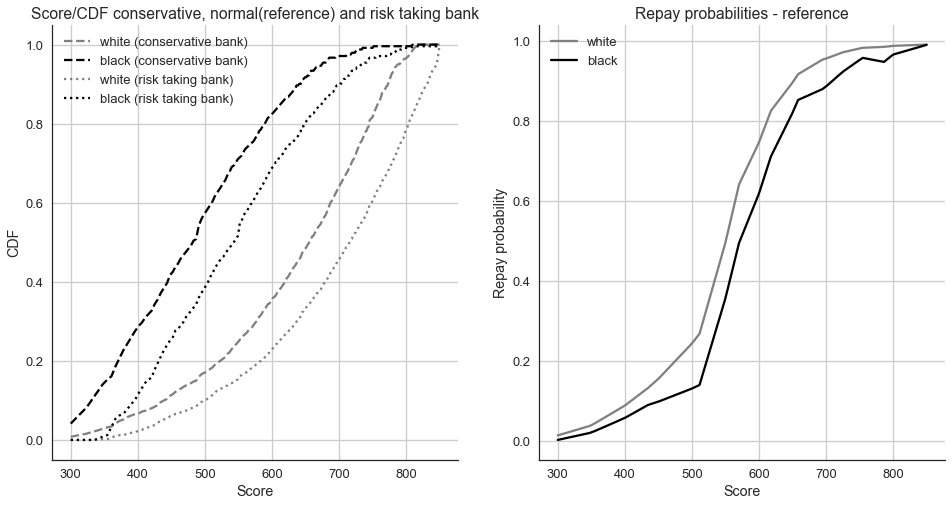

In [4]:
#customers.shape = XxYxZ; X=Groups(white,black), Y=Banks, Z=Individual scores
customer_scores = sf.get_customers(ref_customers, score_shifts, score_range)

#customer_cdfs.shape = XxYxZ, X=Groups, Y=Banks, Z= CDF for score range
customer_cdfs = sf.get_customer_cdfs(customer_scores, scores_list)

#customer_pis.shape = XxYxZ, X=Groups, Y=Banks, Z= distribution value for every score range
customer_pis = sf.get_customer_pis(customer_cdfs)

fig, ax = plt.subplots(1,2,figsize=(16,8));     
ax[0].plot(scores_list,customer_cdfs[0][0],'--',color="grey", label='white (conservative bank)')
ax[0].plot(scores_list,customer_cdfs[1][0],'--',color='black',label='black (conservative bank)')
#ax[0].plot(scores_list,customer_cdfs[0][1],color="grey", label='white (reference bank)')  
#ax[0].plot(scores_list,customer_cdfs[1][1],color='black',label='black (reference bank)')
ax[0].plot(scores_list,customer_cdfs[0][2],':',color="grey", label='white (risk taking bank)')
ax[0].plot(scores_list,customer_cdfs[1][2],':',color='black',label='black (risk taking bank)')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("Score/CDF conservative, normal(reference) and risk taking bank")
ax[0].set_xlabel("Score")
ax[0].set_ylabel("CDF")
ax[0].legend()
ax[0].grid()


ax[1].plot(scores_list,repays[group_names[0]],label='white',color="grey")
ax[1].plot(scores_list,repays[group_names[1]],color='black',label='black')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title("Repay probabilities - reference")
ax[1].set_xlabel("Score")
ax[1].set_ylabel("Repay probability")
ax[1].legend()
ax[1].grid()



# 0.3 Visualize interest rates and compute their intersection

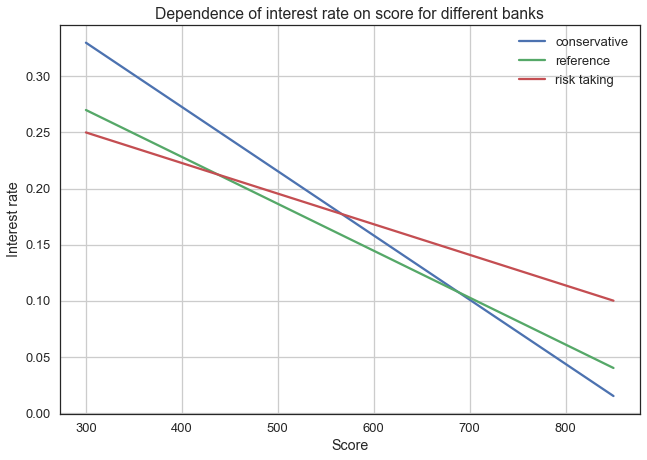

Interest rate intersections: [688.23529411764707, 437.50000000000011, 566.66666666666674]


/home/michal/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


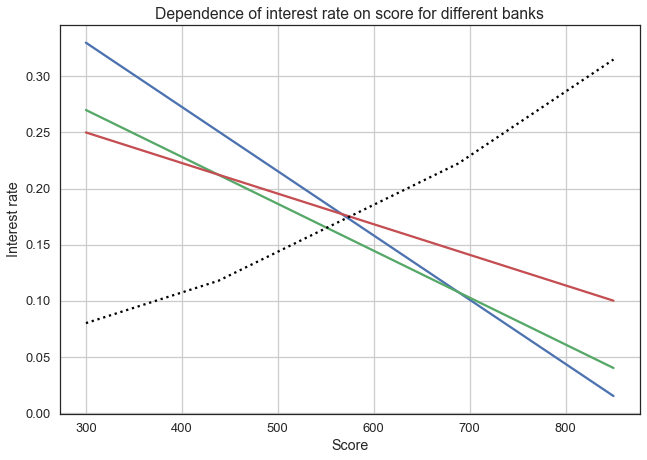

In [5]:
##TODO detect if which intersection is valid
score_interest_intersect = []    
for i in range(0,N_banks): 
    plt.plot(score_range,interest_rates[i], label=bank_names[i])
    a1= array([score_range[0],interest_rates[i][0]])
    a2= array([score_range[1],interest_rates[i][1]])
    
    if i < N_banks-1:
        b1= array([score_range[0],interest_rates[i+1][0]])
        b2= array([score_range[1],interest_rates[i+1][1]])
    else:
        b1= array([score_range[0],interest_rates[0][0]])
        b2= array([score_range[1],interest_rates[0][1]])
        
    interest_intersect = sf.seg_intersect(a1,a2,b1,b2)
    score_interest_intersect.append(interest_intersect[0])

plt.ylabel('Interest rate')
plt.xlabel('Score')
plt.title('Dependence of interest rate on score for different banks')
plt.grid()
plt.legend(loc="upper right")
plt.show()

print("Interest rate intersections: " + str(score_interest_intersect))


#get score mapping to interest rates for different banks
score_interest_rates = sf.get_i_rates(interest_rates,score_range)

# 1.1 Get customer utility curve (based on score and i-rate)

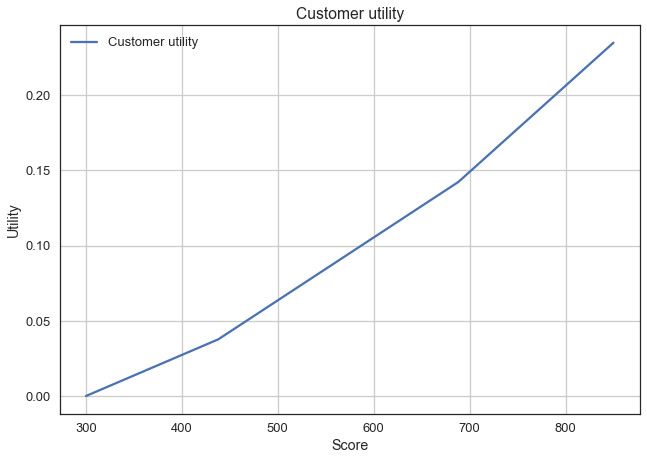

In [6]:
customer_util=[]
for i in range(0,len(interest_rates)):
    slope=(interest_rates[i][1]-interest_rates[i][0])/(score_range[1]-score_range[0])
    tmp_util = [] 
    for j in range(0,score_range[1]-score_range[0]+1):
        tmp_util.append(interest_rates[i][0]+j*slope)
    customer_util.append(tmp_util) 

customer_util = np.amin(customer_util, axis=0)
customer_util = -customer_util+np.max(customer_util)
#print(-customer_util+np.max(customer_util))

plt.plot(range(score_range[0],score_range[1]+1),customer_util, label="Customer utility")
plt.ylabel('Utility')
plt.xlabel('Score')
plt.title('Customer utility')
plt.grid()
plt.legend(loc="upper left")
plt.show()

# 1.2 Get outcome curves

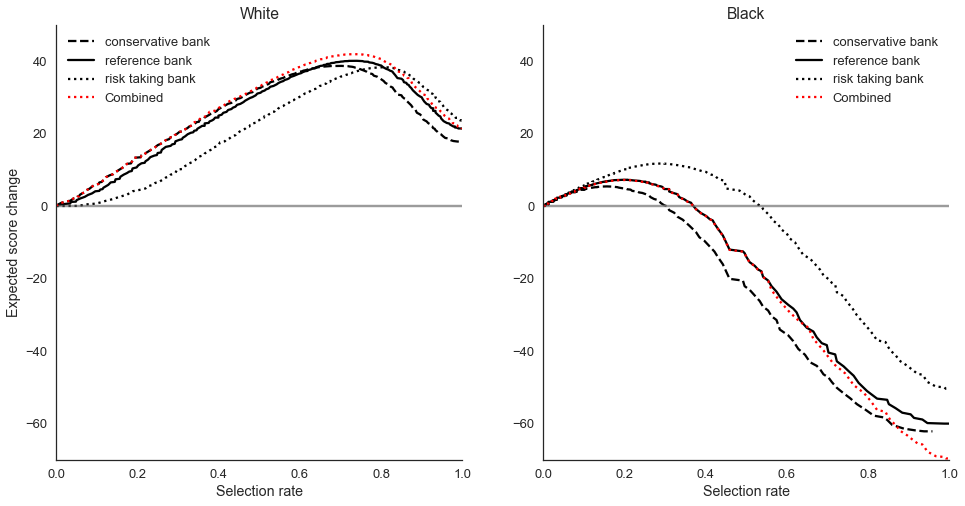

In [7]:
# to get loan repay probabilities for a given score
loan_repaid_probs = [lambda i: repays[group_names[0]][scores[scores.get_loc(i,method='nearest')]], 
                     lambda i: repays[group_names[1]][scores[scores.get_loc(i,method='nearest')]]]
# get outcome curves
customer_outcome_curves = []
customer_rate_index = []
for i in range(0,len(customer_pis)):
    tmp_curves = []
    tmp_rate_index = []
    for j in range(0, len(customer_pis[i])):
            tmp_curves.append(dlo.get_outcome_curve(loan_repaid_probs[i],customer_pis[i][j],scores,impact))
            tmp_rate_index.append(list(reversed(1- customer_cdfs[i][j])))
    customer_outcome_curves.append(tmp_curves)
    customer_rate_index.append(tmp_rate_index)
                                  
fig, ax = plt.subplots(1,2,figsize=(16,8));                                   
for i in range(0, len(customer_outcome_curves)):
    ax[i].set_title(group_names[i])  
    for j in range(0, len(customer_outcome_curves[i])):
        label = bank_names[j] +" bank"
        ax[i].plot(customer_rate_index[i][j],customer_outcome_curves[i][j],color='black',LineStyle=bank_line_style[j], label= label)
        ax[i].set_xlabel('Selection rate');
        ax[i].set_ylim([-70,50])
        ax[i].set_xlim([0,1])
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].axhline(0,LineStyle='-', color='grey',alpha=0.4)

ax[0].set_ylabel('Expected score change')


#combined score have the same form XxYxZ; X=group Y=1 Z=values
combined_scores = sf.get_combined_scores(customer_scores,score_interest_intersect)
combined_cdfs = sf.get_customer_cdfs([[np.sort(combined_scores[0])],[np.sort(combined_scores[1])]],scores_list)
combined_pis = sf.get_customer_pis(combined_cdfs)
combined_rate_index = []
combined_outcome_curves = []

for i in range(0,N_groups):
    combined_rate_index.append([list(reversed(1- combined_cdfs[i][0]))])
    combined_outcome_curves.append([dlo.get_outcome_curve(loan_repaid_probs[i],combined_pis[i][0],scores,impact)])
    ax[i].plot(combined_rate_index[i][0],combined_outcome_curves[i][0],color='red',LineStyle=":", label= "Combined")
    ax[i].legend()



# 1.3 Get bank utility curves

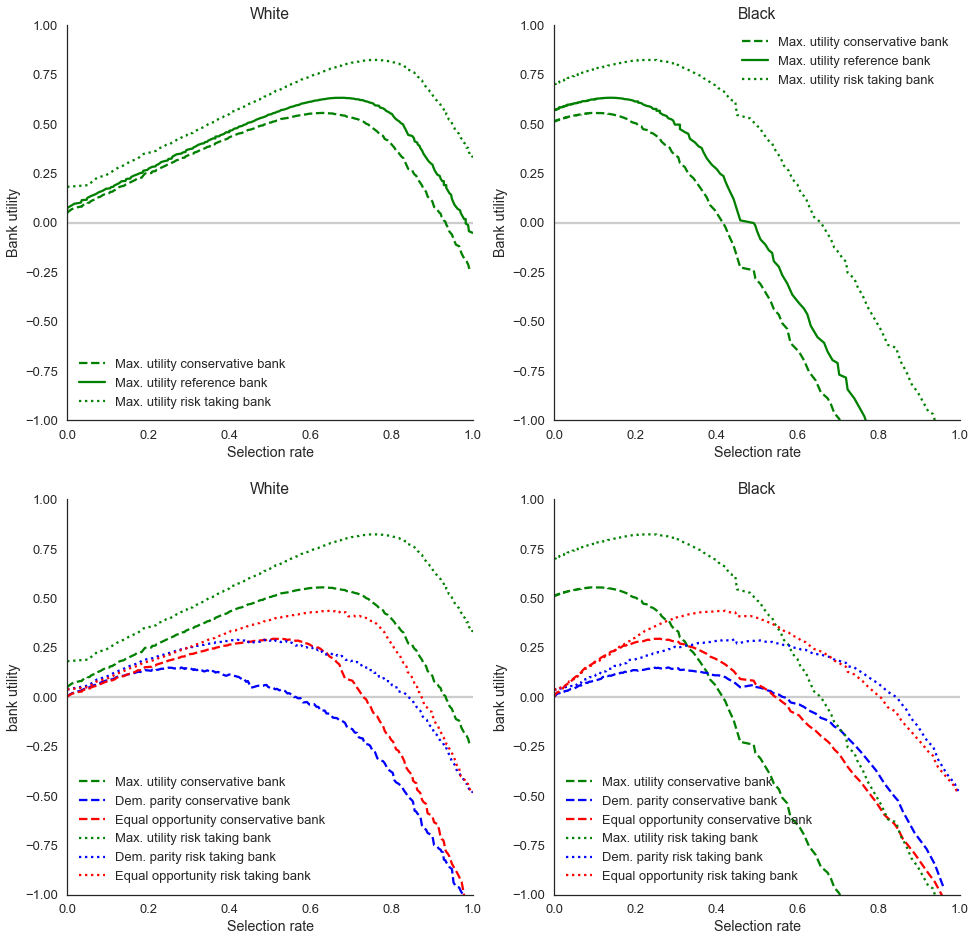

In [8]:
# get bank utility curves
# XY_bank_utility_curves.shape= XxYxZ; X=bank(conservative, normal, risk taking) Y=group(White, Black) Z=values

MP_bank_utility_curves = []
DP_bank_utility_curves = []
EO_bank_utility_curves = []

for i in range(0,N_banks):
    tmp_pis = np.vstack([customer_pis[0][i], customer_pis[1][i]])
    tmp_cdfs = np.vstack([customer_cdfs[0][i], customer_cdfs[1][i]])
    
    tmp_bank_utility_curves = dlo.get_utility_interest_curve_range(loan_repaid_probs, tmp_pis, scores, score_range, interest_rates[i], utils=util_repay[util_repay_selecter])
    util_MP = np.amax(tmp_bank_utility_curves, axis=1)
    MP_bank_utility_curves.append(np.vstack([tmp_bank_utility_curves[0] + util_MP[1], tmp_bank_utility_curves[1]+ util_MP[0]]))
    DP_bank_utility_curves.append(dlo.get_utility_curves_dempar(tmp_bank_utility_curves,np.vstack(tmp_cdfs),group_size_ratio, scores))
    EO_bank_utility_curves.append(dlo.get_utility_curves_eqopp(tmp_bank_utility_curves,loan_repaid_probs,tmp_pis,group_size_ratio, scores))

# bank_utility_curves.shape= WxXxYxZ; W=policy(MP, DP, EO) X=bank(conservative, normal, risk taking) Y=group(White, Black) Z=values
bank_utility_curves = [MP_bank_utility_curves, DP_bank_utility_curves, EO_bank_utility_curves]
                                  
fig, ax = plt.subplots(2,2,figsize=(16,16)); 

for i in range(2):
    for j in range(2):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].axhline(0,LineStyle='-', color='grey',alpha=0.4)

for i in range(0, N_groups):
    for j in range(0, N_banks):
        label = policy_names[0] + " " + bank_names[j] + " bank"
        ax[0,i].plot(customer_rate_index[i][j], bank_utility_curves[0][j][i], color=policy_colors[0],LineStyle=bank_line_style[j] , label=label)
    ax[0,i].set_title(group_names[i])  
    ax[0,i].set_xlabel('Selection rate')
    ax[0,i].set_ylabel('Bank utility')
    ax[0,i].set_ylim([-1,1])
    ax[0,i].legend()
    ax[0,i].set_xlim([0,1])  

for i in range(0, N_groups):
    for j in range(0, N_banks):
        for k in range(0, N_policy):
            label = policy_names[k] + " " + bank_names[j] + " bank"
            if j !=1:
                ax[1,i].plot(customer_rate_index[i][j], bank_utility_curves[k][j][i], color=policy_colors[k],LineStyle=bank_line_style[j] , label=label)
    ax[1,i].set_title(group_names[i])  
    ax[1,i].set_xlabel('Selection rate')
    ax[1,i].set_ylabel('bank utility')
    ax[1,i].set_ylim([-1,1])
    ax[1,i].legend()
    ax[1,i].set_xlim([0,1])



 # 2.1 Calculate next step scores

In [9]:
#get extremes for Max utility strategy
MP_max_rate = np.zeros([N_groups,N_banks])
for i in range(0, N_groups):
    for j in range(0,N_banks):
        MP_max_rate[i][j] = customer_rate_index[i][j][np.argmax(MP_bank_utility_curves[j][i])]
print(MP_max_rate)


next_ref_customer_scores = []
for i in range(0, N_groups):
    next_ref_customer_scores.append(np.zeros(len(ref_customers[i])))

    for j in range(len(ref_customers[i])-1,-1,-1):
        selection_rate = 1-j/len(ref_customers[i])

        if selection_rate <= MP_max_rate[i][-1]:
            #print(selection_rate)
            optimal_bank = sf.get_minimal_interest_bank(score_interest_rates,customer_scores,N_banks, i, j)
            #print(optimal_bank)
            for k in range(0,len(MP_max_rate[i])):
                if selection_rate <= MP_max_rate[i][k] and optimal_bank == k:
                    if sf.get_repay_outcome(loan_repaid_probs[i](ref_customers[i][j])):
                        next_ref_customer_scores[i][j]=ref_customers[i][j] + score_change_repay
                        #print("bank: "+ str(k) + " score before: "+ str(ref_customers[i][j]) +" score after: "+ str(next_ref_customer_scores[i][j]))
                    else:
                        next_ref_customer_scores[i][j]=ref_customers[i][j] + score_change_default
                        #print("bank: "+ str(k) + " score before: "+ str(ref_customers[i][j]) +" score after: "+ str(next_ref_customer_scores[i][j]))
                    break
                elif selection_rate > MP_max_rate[i][k] and optimal_bank == k:
                    optimal_bank = optimal_bank + 1
        else:
            next_ref_customer_scores[i][j]=ref_customers[i][j]
            
    next_ref_customer_scores[i][next_ref_customer_scores[i] < score_range[0]] = score_range[0]        
    next_ref_customer_scores[i][next_ref_customer_scores[i] > score_range[1]] = score_range[1]
    next_ref_customer_scores[i]=np.sort(next_ref_customer_scores[i])

[[ 0.62874251  0.6746507   0.75648703]
 [ 0.09917355  0.14049587  0.23140496]]


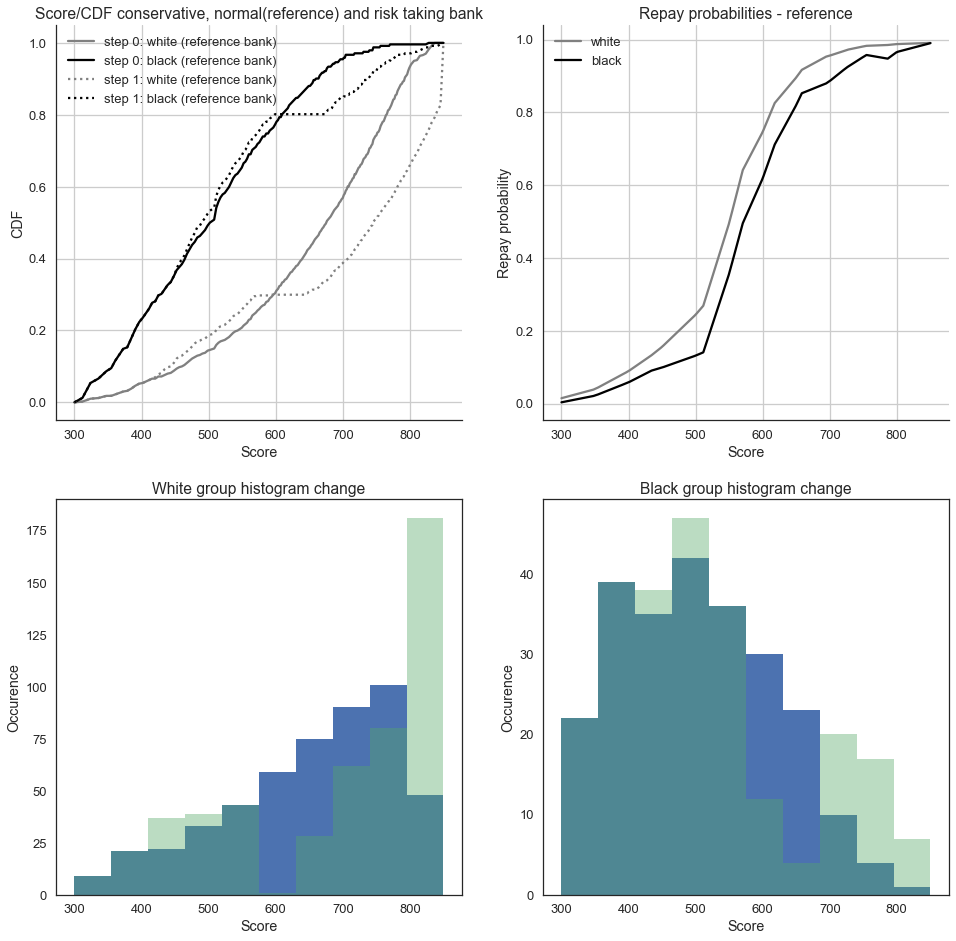

In [10]:
#print(MP_max_rate)
next_customer_scores = sf.get_customers(next_ref_customer_scores, score_shifts, score_range)
#next_customer_cdfs.shape = XxYxZ, X=Groups, Y=Banks, Z= CDF for score range
next_customer_cdfs = sf.get_customer_cdfs(next_customer_scores, scores_list)

fig, ax = plt.subplots(2,2,figsize=(16,16));     
#ax[0].plot(scores_list,next_customer_cdfs[0][0],'--',color="grey", label='white (conservative bank)')
#ax[0].plot(scores_list,next_customer_cdfs[1][0],'--',color='black',label='black (conservative bank)')
ax[0][0].plot(scores_list,customer_cdfs[0][1],color="grey", label='step 0: white (reference bank)')  
ax[0][0].plot(scores_list,customer_cdfs[1][1],color='black',label='step 0: black (reference bank)')
ax[0][0].plot(scores_list,next_customer_cdfs[0][1],':',color="grey", label='step 1: white (reference bank)')  
ax[0][0].plot(scores_list,next_customer_cdfs[1][1],':',color='black',label='step 1: black (reference bank)')
#ax[0].plot(scores_list,customer_cdfs[0][2],':',color="grey", label='white (risk taking bank)')
#ax[0].plot(scores_list,customer_cdfs[1][2],':',color='black',label='black (risk taking bank)')
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['top'].set_visible(False)
ax[0][0].set_title("Score/CDF conservative, normal(reference) and risk taking bank")
ax[0][0].set_xlabel("Score")
ax[0][0].set_ylabel("CDF")
ax[0][0].legend()
ax[0][0].grid()

ax[0][1].plot(scores_list,repays[group_names[0]],label='white',color="grey")
ax[0][1].plot(scores_list,repays[group_names[1]],color='black',label='black')
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)
ax[0][1].set_title("Repay probabilities - reference")
ax[0][1].set_xlabel("Score")
ax[0][1].set_ylabel("Repay probability")
ax[0][1].legend()
ax[0][1].grid()

ax[1][0].hist(ref_customers[0], range=score_range,label='step 0 (reference bank)')
ax[1][0].hist(next_ref_customer_scores[0],alpha=0.4,range=score_range, label='step 1 (reference bank)')
ax[1][0].set_title("White group histogram change")
ax[1][0].set_ylabel("Occurence")
ax[1][0].set_xlabel("Score")

ax[1][1].hist(ref_customers[1],range=score_range,label='step 0 (reference bank)')
ax[1][1].hist(next_ref_customer_scores[1],alpha=0.4, range=score_range,label='step 0 (reference bank)')
ax[1][1].set_title("Black group histogram change")
ax[1][1].set_ylabel("Occurence")
ax[1][1].set_xlabel("Score")